In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2  # Pastikan menggunakan 'l2' dengan huruf kecil
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib
cwd = os.getcwd()
used_dataset_dir = os.path.join(cwd, 'Used_Dataset/cleaned_data')
train_data = pd.read_csv(os.path.join(used_dataset_dir, 'cleaned_data_2020_2022.csv'))
display(train_data.head())
display(train_data.tail())
display(train_data.isnull().sum())
display(train_data.shape)


,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,rad(m)
0,2020-01-01,25.2,32.0,27.0,82.0,16.5,6.5,7.0,300.0,3.000000,W,-0.101338
1,2020-01-02,25.6,31.0,27.9,78.0,5.2,3.5,8.0,270.0,4.000000,W,-0.080959
2,2020-01-03,25.3,31.5,27.6,82.0,1.5,5.9,10.0,280.0,6.000000,W,-0.038172
3,2020-01-05,25.6,31.3,28.6,81.0,8.1,8.0,260.0,6.0,3.133748,NaN,-0.007169
4,2020-01-06,25.5,30.6,27.8,80.0,7.5,6.6,7.0,260.0,6.000000,W,-0.027437


,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,rad(m)
701,2022-12-27,25.5,29.5,27.5,83.0,6.0,1.2,9.0,270.0,6.0,NaN,-0.024320
702,2022-12-28,24.5,29.1,26.9,84.0,2.3,0.0,9.0,270.0,5.0,NaN,-0.030015
703,2022-12-29,24.0,30.1,27.0,84.0,35.6,3.2,8.0,260.0,4.0,NaN,0.005127
704,2022-12-30,25.9,30.0,27.6,83.0,1.0,4.9,7.0,310.0,3.0,NaN,-0.009264
705,2022-12-31,24.9,32.2,27.7,83.0,0.0,0.6,7.0,280.0,3.0,NaN,-0.401817


Date         0
Tn           0
Tx           0
Tavg         0
RH_avg       0
RR           0
ss           0
ff_x         1
ddd_x       27
ff_avg       0
ddd_car    421
rad(m)       0
dtype: int64

(706, 12)

In [29]:
# Fungsi untuk klasifikasi kondisi berdasarkan aturan yang lebih dekat antara Aman dan Tidak Aman
def advanced_condition_classifier(row):
    Tn = row['Tn']  # Minimum Temperature
    Tx = row['Tx']  # Maximum Temperature
    Tavg = row['Tavg']  # Average Temperature
    RH_avg = row['RH_avg']  # Average Relative Humidity
    ff_avg = row['ff_avg']  # Average Wind Speed
    rad_m = row['rad(m)']  # Normalized tidal height (meters)

    # Klasifikasi Aman (Safe)
    if (24 <= Tavg <= 30) and (60 <= RH_avg <= 80) and (ff_avg < 5) and (rad_m < 1.0):
        return 'Aman'

    # Klasifikasi Tidak Aman (Unsafe)
    if (Tx > 35 and RH_avg > 85):
        return 'Tidak Aman'
    elif (Tavg > 30 and RH_avg > 80 and ff_avg > 6):
        return 'Tidak Aman'
    elif (rad_m > 1.0 and Tx > 36):
        return 'Tidak Aman'
    elif ff_avg > 8:
        return 'Tidak Aman'

    # Fallback ke Tidak Aman jika tidak memenuhi aturan apapun
    return 'Tidak Aman'

# Menambahkan kolom 'Condition' berdasarkan fungsi di atas
train_data['Condition'] = train_data.apply(advanced_condition_classifier, axis=1)

# Menyandikan label menjadi numerik (Aman: 0, Tidak Aman: 1)
condition_mapping = {'Aman': 0, 'Tidak Aman': 1}
train_data['Condition'] = train_data['Condition'].map(condition_mapping)

# Menampilkan hasil klasifikasi
print(train_data[['Date', 'Condition']].head())


         Date  Condition
0  2020-01-01          1
1  2020-01-02          0
2  2020-01-03          1
3  2020-01-05          1
4  2020-01-06          1


In [30]:
condition_counts = train_data['Condition'].value_counts()
for label, count in condition_counts.items():
    condition_name = [key for key, value in condition_mapping.items() if value == label][0]
    print(f"{condition_name}: {count}")


Tidak Aman: 456
Aman: 250


In [31]:
from sklearn.preprocessing import MinMaxScaler

# Pilih fitur numerik untuk normalisasi
numerical_features = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']

# Normalisasi data
scaler = MinMaxScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Menghapus nilai yang hilang
merged_data = train_data.dropna(subset=numerical_features + ['Condition'])

# Menampilkan data setelah normalisasi
print(merged_data.head())


         Date        Tn        Tx      Tavg    RH_avg    RR   ss   ff_x  \
0  2020-01-01  0.565217  0.792208  0.500000  0.642857  16.5  6.5    7.0   
1  2020-01-02  0.623188  0.662338  0.660714  0.500000   5.2  3.5    8.0   
2  2020-01-03  0.579710  0.727273  0.607143  0.642857   1.5  5.9   10.0   
3  2020-01-05  0.623188  0.701299  0.785714  0.607143   8.1  8.0  260.0   
4  2020-01-06  0.608696  0.610390  0.642857  0.571429   7.5  6.6    7.0   

   ddd_x   ff_avg ddd_car    rad(m)  Condition  
0  300.0  0.40000      W   0.457657          1  
1  270.0  0.60000      W   0.488697          0  
2  280.0  1.00000      W   0.553865          1  
3    6.0  0.42675     NaN  0.601085          1  
4  260.0  1.00000      W   0.570216          1  


In [32]:
from sklearn.model_selection import train_test_split

# Pisahkan fitur dan target
X = merged_data[numerical_features].values
y = merged_data['Condition'].values

# Split data menjadi training dan validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
from imblearn.over_sampling import SMOTE

# Terapkan SMOTE untuk menangani ketidakseimbangan kelas
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Cek distribusi kelas setelah resampling
print(f"Class distribution after resampling:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")


Class distribution after resampling:
0    0.5
1    0.5
Name: proportion, dtype: float64


In [34]:
# Reshape data untuk LSTM input (pastikan data 3D untuk LSTM)
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))


In [35]:
# Define the LSTM model
model = Sequential()

# LSTM Layer with L2 regularization and Dropout
model.add(LSTM(units=64, return_sequences=False, 
               input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2]), 
               kernel_regularizer=l2(0.01)))  # Perbaikan di sini (gunakan 'l2')
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(BatchNormalization())  # Batch normalization

# Fully connected layer with Dropout
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))  # Dropout

# Output Layer (binary classification)
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model with callbacks
history = model.fit(X_train_resampled, y_train_resampled, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

# Save the model and scaler
model.save('model_lstm.h5')
print("Model saved as 'model_lstm.h5'")
joblib.dump(scaler, 'scaler.pkl')


Epoch 1/50


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5400 - loss: 0.7979 - val_accuracy: 0.6479 - val_loss: 0.7665 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6940 - loss: 0.6720 - val_accuracy: 0.7324 - val_loss: 0.7417 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7435 - loss: 0.5912 - val_accuracy: 0.7817 - val_loss: 0.7177 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8176 - loss: 0.4978 - val_accuracy: 0.8803 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.4725 - val_accuracy: 0.8169 - val_loss: 0.6640 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8421 - loss: 0.4047 - val_accuracy: 0.8732 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8710 - loss: 0.3480 - val_accuracy: 0.8662 - v

Model saved as 'model_lstm.h5'


['scaler.pkl']

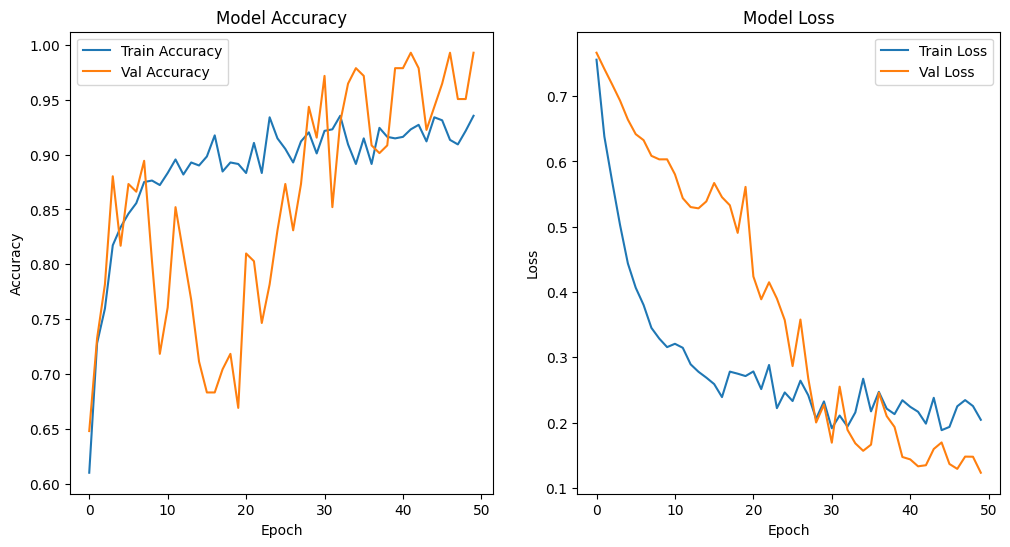

In [36]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


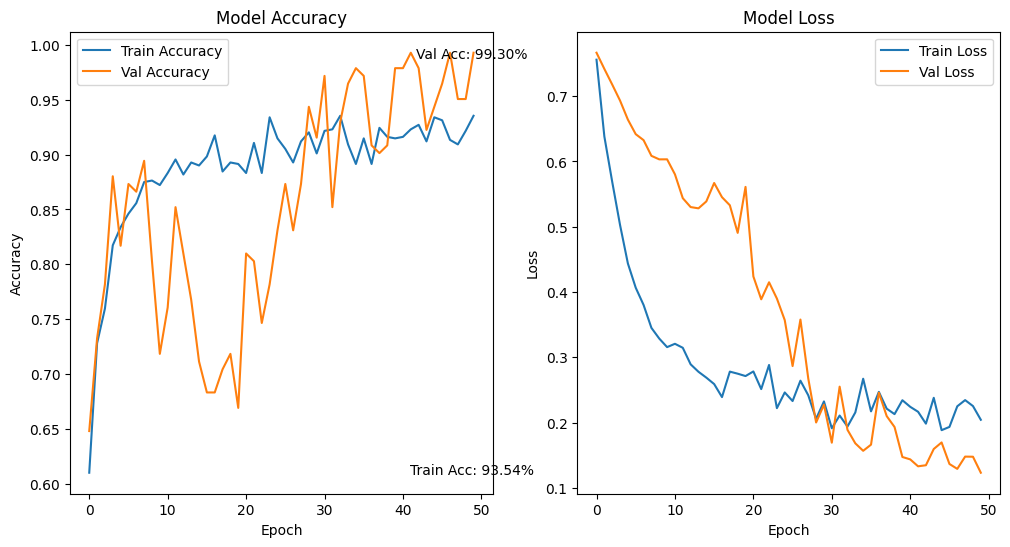

In [37]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

# Add percentage labels on the accuracy plot
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Display the final accuracy percentage on the plot
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100
plt.text(0.95, 0.05, f'Train Acc: {train_acc:.2f}%', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.95, 0.95, f'Val Acc: {val_acc:.2f}%', ha='center', va='center', transform=plt.gca().transAxes)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()
